In [174]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, accuracy_score

from pandas.plotting import scatter_matrix
#import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from project_helper import VolFeatures, FuturesCloseData

In [88]:
import pickle
file = open("full_features.pkl",'rb')
full_features = pickle.load(file)

In [149]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
x_dict={}
y_dict={}
for inst in instrument_list:
    #y_dict[inst] = 2 * (full_features[inst][inst] >=0)- 1
    y_dict[inst] = (full_features[inst][inst]>=0).astype(int)    
    x_dict[inst] = full_features[inst].drop([inst], axis=1)

In [177]:
class MLModel:
    def __init__(self,model,inst,x_dict,y_dict):
        self.inst = inst
        self.x = x_dict[inst]
        self.y = y_dict[inst]

        self.model = model
        self.accuracy_train = None
        self.accuracy_test = None
    
    def split_data(self):
        self.X_train, \
        self.X_test, \
        self.y_train, \
        self.y_test = train_test_split(self.x, self.y, test_size=0.50, shuffle=False)


    def train_model(self):
        #self.model = OLS(self.y_train, self.X_train)
        #self.model = self.model.fit()
        self.model = self.model(random_state=0).fit(self.X_train,self.y_train)


    def evaluate_model(self):
        self.accuracy_train = self.model.score(self.X_train, self.y_train)
        self.accuracy_test = self.model.score(self.X_test, self.y_test)

        
    
class ModelBuilder:
    def __init__(self,inst,x_dict,y_dict):
        #self.model = None
        self.logistic_model = MLModel(LogisticRegression,inst,x_dict,y_dict)
        self.rf_model = MLModel(RandomForestClassifier,inst,x_dict,y_dict)
        self.tree_model = MLModel(DecisionTreeClassifier,inst,x_dict,y_dict)
        self.boosted_tree_model = MLModel(GradientBoostingClassifier,inst,x_dict,y_dict)

        self.models = {'logistic':self.logistic_model,
                 'rf':self.rf_model,
                 'tree':self.tree_model,
                    'boosted_tree':self.boosted_tree_model}


        self.accuracy_train = None
        self.accuracy_test = None
        #ml_models = [LinearRegression, ]

        
    def run(self):
        {model.split_data() for model in self.models.values()}
        {model.train_model() for model in self.models.values()}
        {model.evaluate_model() for model in self.models.values()}
        return self


In [178]:
models = {inst: ModelBuilder(inst,x_dict,y_dict) for inst in instrument_list}
models = {inst: model.run() for inst,model in models.items()}

In [180]:

logistic = pd.DataFrame([(inst, model.models['logistic'].accuracy_train) for inst,model in models.items()],columns=['asset','logistic']).set_index('asset')
tree = pd.DataFrame([(inst, model.models['tree'].accuracy_train) for inst,model in models.items()],columns=['asset','tree']).set_index('asset')
rf = pd.DataFrame([(inst, model.models['rf'].accuracy_train) for inst,model in models.items()],columns=['asset','rf']).set_index('asset')
boosted_tree = pd.DataFrame([(inst, model.models['boosted_tree'].accuracy_train) for inst,model in models.items()],columns=['asset','boosted_tree']).set_index('asset')

train_accuracies = logistic.join(tree).join(rf).join(boosted_tree)
train_accuracies

,logistic,tree,rf,boosted_tree
asset,,,,
ES,0.610315,1.0,1.0,0.982808
NQ,0.613181,1.0,1.0,0.979943
CD,0.593123,1.0,1.0,0.982808
EC,0.618911,1.0,1.0,0.979943
JY,0.604585,1.0,1.0,0.982808
MP,0.593123,1.0,1.0,1.000000
TY,0.590258,1.0,1.0,0.994269
US,0.610315,1.0,1.0,0.988539
C,0.524355,1.0,1.0,0.979943


In [183]:

logistic = pd.DataFrame([(inst, model.models['logistic'].accuracy_test) for inst,model in models.items()],columns=['asset','logistic']).set_index('asset')
tree = pd.DataFrame([(inst, model.models['tree'].accuracy_test) for inst,model in models.items()],columns=['asset','tree']).set_index('asset')
rf = pd.DataFrame([(inst, model.models['rf'].accuracy_test) for inst,model in models.items()],columns=['asset','rf']).set_index('asset')
boosted_tree = pd.DataFrame([(inst, model.models['boosted_tree'].accuracy_test) for inst,model in models.items()],columns=['asset','boosted_tree']).set_index('asset')

test_accuracies = logistic.join(tree).join(rf).join(boosted_tree)
test_accuracies.to_csv('test_accuracies.csv')

In [207]:
imp_df = pd.DataFrame()
for inst in instrument_list:
    feature_imp_df = pd.DataFrame(models[inst].models['tree'].model.feature_importances_,columns=[inst])
    feature_imp_df.index = x_dict[inst].columns
    imp_df = imp_df.join(feature_imp_df,how='outer')

In [209]:
imp_df.to_csv('imp_df.csv')

In [119]:
{inst: model.accuracy_test for inst,model in models.items()}

{'ES': 0.5457142857142857,
 'NQ': 0.5485714285714286,
 'CD': 0.49142857142857144,
 'EC': 0.4742857142857143,
 'JY': 0.4685714285714286,
 'MP': 0.5514285714285714,
 'C': 0.52,
 'S': 0.5114285714285715,
 'W': 0.4714285714285714,
 'CL': 0.5342857142857143}

In [129]:
inst='ES'
{inst: model.logistic_model.predict(model.X_test).mean() for inst,model in models.items()}

{'ES': 0.9685714285714285,
 'NQ': 0.84,
 'CD': 0.16285714285714287,
 'EC': 0.5171428571428571,
 'JY': 0.6085714285714285,
 'MP': 0.66,
 'C': 0.6914285714285714,
 'S': 0.5314285714285715,
 'W': 0.3057142857142857,
 'CL': 0.9114285714285715}

In [132]:
models[inst].X_train.shape

(349, 45)

In [29]:
accuracy_score(results.predict(X_test)>= 0, y_test)

0.5285714285714286

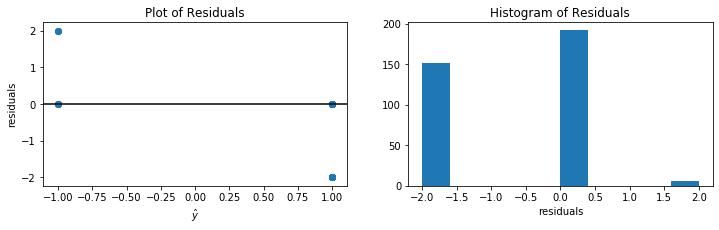

In [36]:
# your code here
y_hat_train = 2 * (results.predict(X_test)>=0)-1
residuals = y_test - y_hat_train
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].scatter(y_hat_train, residuals, alpha=0.5)
ax[0].set_title('Plot of Residuals')
ax[0].set_xlabel(r'$\hat{y}$')
ax[0].set_ylabel('residuals')
ax[0].axhline(0,c='black')

ax[1].hist(residuals)
ax[1].set_title('Histogram of Residuals')
ax[1].set_xlabel(r'residuals')

plt.show()

In [40]:
sum(y_hat_train == 1)

337

In [ ]:
#2.0 y_train long, y_predict short
#-2.0 y_train short, y_predict long